<p align="center">
  <img src="https://github.com/deel-ai/xplique/blob/master/docs/assets/banner.png?raw=true"/>
</p>

---

**Lime**: 📘 <a href="https://deel-ai.github.io/xplique/api/attributions/lime/"> Documentation</a>  |  <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique/blob/master/xplique/attributions/lime.py"> Source</a>  | 📰 <a href="https://arxiv.org/abs/1602.04938"> Original Paper</a>

**KernelShap**: 📘 <a href="https://deel-ai.github.io/xplique/api/attributions/kernel_shap/"> Documentation</a>  |  <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique/blob/master/xplique/attributions/kernel_shap.py"> Source</a>  | 📰 <a href="https://arxiv.org/abs/1705.07874"> Original Paper</a>

🦊 <a href="https://github.com/deel-ai/xplique/blob/master/TUTORIALS.md"> More Xplique tutorials</a>

---

_Author: Antonin Poché_

---


# Welcome to the **Lime and KernelShap attribution** tutorial

In this tutorial, we will present the Lime and KernelShap methods and few tips to use the right parameters. We also answer to frequently asked questions and dig into the details of the parameters through examples.

The KernelShap method inherit from the Lime method and set several parameters of the perturbation function. As such the parameters of the KernelShap method are included in the parameters of the Lime method and they have the same impact on the results. Therefore, they will be treated together in this tutorial.

For the parameters impact examples, the common parameters will be studied first through KernelShap and then the specific Lime parameters with be explored.

💡 The Lime and Kernelshap attribution methods were integrated into the Xplique framework and we propose here to have an overview of the possibilities you have to play with those methods to explain the outputs of your model.

---

# **Table of content:**

- [The methods](#intro)

- [Parameters overview](#overview)

- [Parameters tuning tips](#tips)

- [Frequently asked questions](#faq)

- [Utilization and parameters impact examples](#examples)

    - [Set-up](#setup)

    - [Methods simple utilization](simple)

    - [Common parameters influence](#influence)

    - [Lime specific parameters influence](#lime_influence)

# <a name="intro"> The methods

### **Attribution methods**

The main objective in attributions techniques is to highlight the discriminating variables for decision-making. For instance, with Computer Vision (CV) tasks, the main goal is to underline the pixels contributing the most in the input image(s) leading to the model’s output(s).



### **Perturbation-based attribution methods**

Perturbation-based methods are one of the two groups of attribution methods with back-propagation methods. Those methods perturb the inputs and look at the evolution of the output depending on those perturbation. The idea is that perturbing an important input will have a huge impact on the output. It was first introduced in 2013, with the occlusion method from <a href="https://arxiv.org/abs/1311.2901">Zeiler et Fergus</a>.  Perturbation-based methods can be seen as black-box methods as they only need the model to make inferences and do not look inside the model.

### **The Lime method**

The Lime method try to find a function $g$ that approximate our model $f$ in the vicinity of $x$ the studied input sample. The goal is to find a function $g$ with a behavior the closest possible to $f$ but remaining simple and thus interpretable. The coefficients of the learnt $g$ function are given as an explanation.

Before explaining how $g$ is obtained, it is important to distinguish between features and interpretable data representations. For human to understand explanations, those need to be in an intepretable space. In Lime, the interpretable space can be seen as a space where features of an input $x$ were grouped together. (For example group letters as words for text or pixels as super-pixels for images). All elements $e$ have in interpreatable representation $e'$ in the intepretable space, $g$ input space is the interpretable space.

To approximate $f$ with $g$, perturbed samples $z$ are generated aroud the studied input $x$, a random number of features is perturbed to a given reference value. The model $f$ allow us to make label for those samples $z$. The method also define a similarity function $\pi_x$ that estimates the similarity between the studied sample $x$ and the generated samples $z$. Then the function $g$ is trained on those samples/labels pairs (in the intepretable space) using the similarity function to weight the impact of each sample.

The authors introduce two elements, the first, $\mathcal{L}(f,g,\pi_x)$ a measure of how unfaithful $g$ is in approximating $f$ in the locality defined by $\pi_x$. The second, $\Omega(g)$ a measure of the complexity of $g$ (as opposed to interpretability), (an example would be the depth of a decision tree). Finally, the explainer is defined as:
$$\xi(x) = \underset{g\in G}{\mathrm{argmin}} \space\space \mathcal{L}(f,g,\pi_x) + \Omega(g)$$

In Xplique as in the original paper, we take $g$ from the ensemble of linear models, such that $g(z') = w_{g} . z'$. Then the explanations are the coefficients $w_{\xi(x)}$.

To further understand the method, some elements need to be defined. It will also help to understand the difference between the KernelShap method we implemented.
- The interpretable space for images are set of super-pixels. Text are not supported by default while time series and tabular do not need interpretable spaces.
- The function to generate $z$ perturbed samples around the input $x$ is the perturbation function. A reference value and a perturbation probability are defined, the group of features of a sample $z'$ (i.e super-pixel) are either perturbed to the reference value or left untouched. Each group of features have the same probability to be perturbed. This was the perturbation proposed by the paper and implemented in the Xplique library.
- The similarity kernel $\pi_x$ implemented in xplique and given in the paper is $\pi_x(z) = exp(-D(x,z)^2/\sigma^2)$ with $D$ a distance and $\sigma$ the width.
- The default intepretable model $g$ implemented is also the one evoqued in the paper, a Lasso regressor.

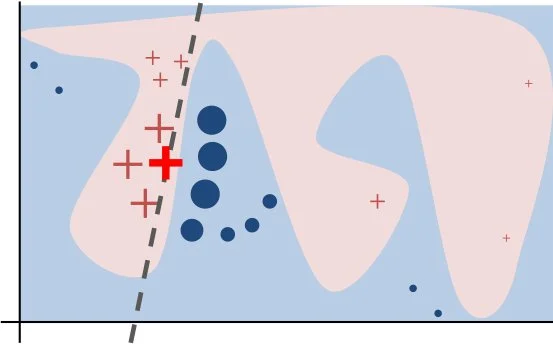

Figure 3 from <a href="https://arxiv.org/abs/1602.04938"> the Lime paper by Ribeiro et al. in 2016</a> a toy example to present Lime intuition.

In the above image we can see:
- The studied input $x$ which is the big red cross.
- The model $f$ is represented by the decision boundary between the blue and red regions.
- The others red crosses and the blue disks represent the $z$ samples generated around $x$.
- The dotted line represent the $g$ function which is a local approximation of the model.
- The size of the different $z$ element depict the similarity between those elements and $x$, thus the similarity $\pi_x(z)$.

### **The KernelShap method**

In their [paper](https://arxiv.org/abs/1705.07874), the authors propose to use:
> SHAP (SHapley Additive exPlanation) Values as a unified measured of feature importance

The KernelShap method from Xplique is based on the Lime method, it uses shapley values to define the perturbation function, the similarity function and the approximate function.

- The perturbation function, it draws the number of features to perturbed $k$ (with $n$ the total number of features) following the distribution $p$, then the $k$ features are selected randomly and perturbed to the reference value given to the method. $$p(k) = \frac{n-1}{k*(n-k)}$$
- The similarity function $\pi_x$ is defined as the number of perturbed features, $\pi_x = k$.
- The approximation function $g$ is defined as a linear regression.


# <a name="overview">Parameters overview </a>

As most methods of the Xplique library, an explanation method have a few number of attributes (and their default values) useful to increase your explanation quality.

```python
explainer = KernelShap(model: Callable,
                       batch_size: int = 32,
                       map_to_interpret_space: Optional[Callable] = None,
                       nb_samples: int = 800,
                       ref_value: Optional[np.ndarray] = None)
                       )
```

```python
explainer = Lime(
        self,
        model: Callable,
        batch_size: int = 32,
        interpretable_model: Any = linear_model.Ridge(alpha=2),
        similarity_kernel: Optional[Callable[[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor]] = None,
        pertub_func: Optional[Callable[[Union[int, tf.Tensor],int], tf.Tensor]] = None,
        map_to_interpret_space: Optional[Callable[[tf.Tensor], tf.Tensor]] = None,
        ref_value: Optional[np.ndarray] = None,
        nb_samples: int = 150,
        distance_mode: str = "euclidean",
        kernel_width: float = 45.0,
        prob: float = 0.5
        )
```

**Common parameters:**

- The `batch_size` define the number of inputs to treat simultaneously. (Positive integer).

- The `map_to_interpret_space` is a function used to obtained the interpretable representation of a sample. In practice, it groups features of an input corresponding to the same interpretable feature (e.g super-pixel) together. It allows to transpose from (resp. to) the original input space to (resp. from) the interpretable space. By default, the quickshift function is used. (Segementation function from `skimage.segmentation`).

- The `nb_samples` parameter is the number of perturbed samples generated for each input (images, timeseries). It you refer to the [methods definitions](#intro) is the number of samples used by the $g$ function to learn and approximate the model $f$. (Positive integer).

- The `ref_value` defines the reference value which replaces each feature when the corresponding interpretable feature is set to 0. It should be provided as: a ndarray of shape (1) if there is no channels in your input and (C,) otherwise. The default ref value is set to (0.5,0.5,0.5) for inputs with 3 channels (corresponding to a grey pixel when inputs are normalized by 255) and to 0 otherwise. (Array of float values, one value by channel).

**Lime specific parameters:** (and used values for KernelShap)

- The `interpretable_model` is a model object to train an interpretable model that will approximate the model locally. It correspond to the model behind the $g$ function in [the methods definition](#intro). (KernelShap uses a linear regression). (function from `sklearn.linear_model`).

- The `similarity_kernel` is a function which considering an input, perturbed instances of these input and the interpretable version of those perturbed samples compute the similarities between the input and the perturbed samples. It was described as $\pi_x$ in [the methods definition](#intro). (KernelShap uses the number of perturbed features (super-pixels) ($\pi_x = k$)).

- The `pertub_function` is a function which generate perturbed interpretable samples in the interpretation space from the number of interpretable features (e.g nb of super pixel) and the number of perturbed samples you want per original input. Perturbed features are afterward set to `ref_value`. (KernelShap randomly draws a number of features to perturb $k$ than randomly select $k$ features to perturb).

- The `distance_mode` parameter is used in the default similarity kernel. It defines the distance used. (Either "euclidean" or "cosine").

- The `kernel_width` parameter is the width of your similarity kernel. (Positive value).

- The `prob` parameter is the probability argument for the default pertub function. (Value between 0. and 1.).

The detail on each attribute influence will be provided in the [Common parameters influence](#influence) and [Lime specific parameters influence](#lime_influence) sections.

# <a name="tips">Parameters tuning tips</a>

**Common parameters:**

- The `batch_size` represents the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.

- The `map_to_interpret_space` is a function grouping coherent pixels together (image segmentation). The functions doing segmentation have several parameters, tuning them may take some time. Thus, we suggest to modify it only if the super-pixels do not make sense on your image. For Timeseries, you should also build an identity mapping, see at the end of [the documentation](https://deel-ai.github.io/xplique/api/attributions/lime/) for more information.

- The `nb_samples` represents the number of samples (perturbed sample) used by the estimator for each sample (image, timeseries...). The right setting is the smallest value after which the explanation are stable. This means that more sample will not make the explanation more precise. `nb_samples` default value is (150 for Lime, 800 for KernelShap), the bigger the input size, the bigger should be the number of samples.

- The `ref_value` defines the reference value which replaces each feature when the corresponding interpretable feature is set to 0. It should represent non-information. 0 or the mean of your values are often good values. If you have several channels, the different values should represent the same thing (i.e all zeros or all means along the channel).

**Lime specific parameters:** (and used values for KernelShap)

- The `interpretable_model` parameter represents an interpretable model object, this model is train on pertubed samples to approximate the original model locally. It is hard to predict the impact of such parameter, thus if you not have a deep understanding and a goal in mind, we do not suggest to modify this parameter. (To see the default function, see below in the corresponding paragraph).

- The `similarity_kernel` is a function for measuring the similarity between perturbed samples and the original input. To change this parameter you need to write a custom function, which ask for a good understanding of the method. Therefore, we suggest to modify this function via the `distance_mode` and `kernel_width` parameters. (To see the default function, see below in the corresponding paragraph).

- The `pertub_function` is a function which generate perturbed interpretable samples in the interpretation space. To change this parameter, you also need a custom function. Therefore to modify the `pertub_function` we suggest to do it via the `prob` parameter. (To see the default function, see below with parameter details).

- The `distance_mode` is the dist parameter used by the default `similarity_kernel` function. It is either "euclidean" or "cosine", both are pertinent and should be tried. ("euclidean" is the default).

- The `kernel_width` is the width of the default `similarity_kernel` function. This parameter depend on the input size, the default value is 45, it is tuned for 224x224 images. You may use 1 for tabular data or small time series. While a bigger value should be taken for bigger images. It is important to make it evolving depending on your inputs size otherwise you will get all similarity close to 0 leading to poor performance or errors.

- The `prob` parameter is used by the default `perturb_function`. It determines the probability of a feature (super-pixel) to be perturbed. The value should stay between 0.1 and 0.9. (The default value is 0.5).

# <a name="faq">Frequently asked questions</a>

### **Out of memory error**

You asked too much memory from your RAM. This is usually cause by treating too much samples simultaneously, thus reducing the `batch_size` should resolve your problem. Otherwise you may check if there is nothing else runing on your machine.

### **Which method is the best?**

None, you should try them and compare them, there will always be a case for one method to shine. To compare them you should use the metrics and your own intuition. To learn how to use the metrics, compare the methods and interpret them, please refer to the <a href="https://deel-ai.github.io/xplique/tutorials/"> other Xplique tutorials</a>.

### **The computation time is too long**

For each sample you want an explanation on, the model generate `nb_samples` perturbed images and make inference on each one of them. And a linear model is trained on the generated samples. Therefore it is naturally long, however if you want to reduce this time, you have three possibilities:
- Reduce `nb_samples`, as computation time is linearly correlated to it. However, be careful, the quality of your explanation may decrease.
- Increase the `batch_size`, you machine will thus do bigger computations simultaneously. However it may lead to out of memory errors.
- Finally you can choice to reduce the number of samples (images, timeseries) you want an explanation on. (Maybe wrongly classified samples are more interesting to analyze or if you evaluate your method through metrics, only a part of the test set could be sufficient).

### **The explanation does not make sense**

The two methods have several common parameters, thus if **both methods do not work**, there is a high chance that it comes from the common parameters:
- The `nb_samples` parameters may be too low, without enough samples, the explanation will be noisy/fuzzy. We thus suggest to increase `nb_samples` till it does not affect the explanation anymore. (One image should be enough to determine the appropriate value).
- The `ref_value` parameter may be out of the range of possible values taken by the input. Therefore the model would see values it has never seen and the methods will not be able to make explanations. Make sure to have a `ref_value` between the minimum and the maximum values taken by the inputs.
- The `map_to_interpret_space` may not be appropriate, please refer to the "super-pixels do not correspond to coherent image parts" paragraph below.
- The `targets` parameter of the `explain` method may have not adapted values. It should take values in $\{-1, 0, 1\}$, we often use the model prediction (one hot encoding after argmax) or the dataset labels. For regression, it should be only ones. Verify that your `targets` parameter values are in $\{-1, 0, 1\}$.
- If the model do not work well, it is natural that explaining its behavior will not be understandable. You can come to this conclusion if other explainability methods do not work well either. In this case, you may want to modify your model.
- The method you use may not be adapted to the model or the dataset. You will see it quickly if other explanability methods work well. In this case, you should just use the other methods. For example with tabular data with too many input features, you may need an enormous `nb_samples` for the method to converge, thus it may not be adapted.

In the case where **only the Lime method do not work**, there is a high chance that it comes from the Lime specific parameters:
- Use the same common parameters which are working for the KernelShap method.
- Use the default parameter for `prob` which is 0.5.
- Check if the `kernel_width` is adapted to the size of the input. For 224x224 images, the default value of 45 should work, with smaller images, tabular data or time series, a smaller value should be taken. While bigger images require a bigger value.
- You can try to change the `distance_mode` to either "euclidean" or "cosine".
- Finally if neither of those solutions worked, you may use KernelShap. Keep in mind that it is useless to tune Lime complex parameters to match the parameters set by KernelShap as it would be similar as too use the KernelShap method.

If **only the Kernelshap do not work**, you may set the common parameters with the values which are working for the Lime method. If this is not enough, you may increase `nb_samples` (it may be more than 10 times). Finally, if you still do not obtain results, then we suggest to use the Lime method.

### **The super-pixels do not correspond to coherent image parts**

The only parameter influencing the super-pixels segmentation is `map_to_interpret_space`. This parameter is an instance of a segmentation function, there exist several possible function and all of them have several parameters. Thus, finding the appropriate setting may take some time. Therefore, before modifying it, you should look if the problem remain on several examples and be sure that it is the super-pixels segmentation that is the problem.

If it is a general problem, it may come from the default parameters of the default segmentation function. Those are tuned for 224x224 images, thus they may not match your image caracteristics. You can either change the parameters of the default quickshift function are use another function. You may refer to the `map_to_interpret_space` paragraph in the [common parameters influence](#influence). There are several examples of other segmentation functions.

### **Which parameter should I tune in priority?**

We could say that there are simple and complex parameters in the two methods. Thus beginning with simple parameters should be natural. As such, the simple parameters are:
- common
    - `nb_samples`
    - `ref_value`
- specific to Lime
    - `distance_mode`
    - `kernel_width`
    - `prob`

Other parameters are functions, thus their definition is more complex and use not default ones, you need deep understanding of the method.

### **ZeroDivisionError: Weights sum to zero, can't be normalized**

This error may happen because of two parameters:
- Either the `kernel_width` parameter of the Lime method is too small. Thus you should increase it.
- Or, the `interpretable_model` is Lasso (default for Lime), it has a tendency to set most of the coefficients to zero. Thus changing it to Ridge or to a linear regressor may also resolve the error.

# <a name="examples">Utilization and parameters impact examples</a>

This section will a simple utilization of the methods and then how the parameters impact the explanation. It will be done through examples, therefore, a little set up part to load a model and an image is necessary. For the parameters impact examples, the common parameters will be studied first through KernelShap and then the specific Lime parameters with be explored.

## <a name="sec">Set-up</a>

We start by importing Xplique and some other necessary libraries.

In [ ]:
!pip install -U -q xplique

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 KB 4.4 MB/s eta 0:00:00


In [ ]:
from itertools import product
from math import ceil
from time import time

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn import linear_model
from skimage.segmentation import quickshift, felzenszwalb, watershed, slic
from skimage.color import rgb2gray
from skimage.filters import sobel

import xplique
from xplique.attributions import Lime, KernelShap
from xplique.plots import plot_attributions

Now we will load an image and a well-known model [Inception V3](https://keras.io/api/applications/inceptionv3/).

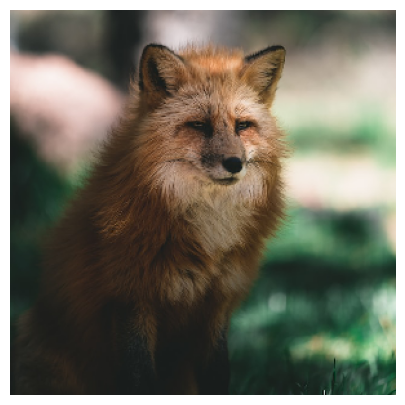

In [ ]:
# load, prepare and show the sample
!wget -q 'https://unsplash.com/photos/XOxsVJmCyxk/download?force=true&w=640' -O 'fox.jpg'

x = np.expand_dims(tf.keras.preprocessing.image.load_img("fox.jpg", target_size=(299, 299)), 0)
x = np.array(x, dtype=np.float32) / 255.0

y = np.expand_dims(tf.keras.utils.to_categorical(277, 1000), 0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

In [ ]:
# load the model
model = tf.keras.applications.InceptionV3()

96112376/96112376 [==============================] - 0s 0us/step


## <a name="simple">Methods simple utilization</a>

This a minimal example on how to apply the SmoothGrad, SquareGrad and VarGrad methods. This focus on the right specification of the methods parameters. For further details and explanations on the attribution explainers API, please refer to the [Feature attribution tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

Lime


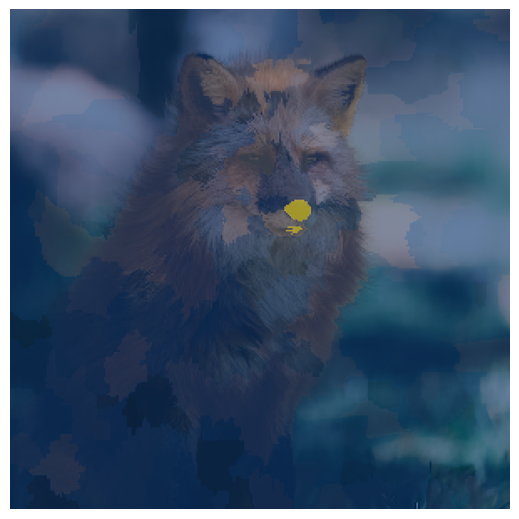

KernelShap


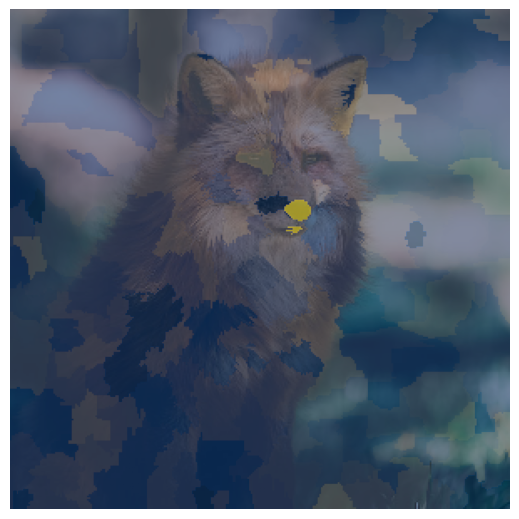

In [ ]:
# define arbitrary parameters (common for all methods)
common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # will use the default function
    "nb_samples": 4000,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
}

lime_specific_parameters = {
    "interpretable_model": linear_model.Ridge(alpha=2),
    "similarity_kernel": None,  # will use the default function
    "pertub_func": None,  # will use the default function
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime": Lime(**common_parameters, **lime_specific_parameters),
    "KernelShap": KernelShap(**common_parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
    plt.show()

The SmoothGrad, SquareGrad and VarGrad methods need some knowledge to set their parameters right. Therefore we propose to summarize those informations in [the parameters tuning tips part](#tips). The parameters are described and explained in the following sections.

## <a name="influence">Common parameters influence</a>

This section will present the influence of each common parameters parameters between Lime and KernelShap, it will be accompanied by visualization to illustrate it. Each parameter will be described one by one.

The KernelShap method inherit from the Lime method and set several parameters of the perturbation function. As such the parameters of the KernelShap method are included in the parameters of Lime and they are the one considered as the common parameters. Their influences are similar between both method, as such, we will use the Kernelshap method to dig into those parameters.

The [lime specific parameters influence](#lime_influence) are treated afterward.

### **batch_size**

The `batch_size` parameter should be a positive integer, it indicates the number of perturbed images treated simultaneously.
- Too small values will increase the execution time.
- Too huge values may lead to out of memory errors.
This parameter should be set taking into account your hardware and the image size. The most simple solution is to used the same batch size you use during the training of your model.

### **map_to_interpret_space**

The `map_to_interpret_space` is a function used to obtained the interpretable representation of a sample. In practice, it groups features of an input corresponding to the same interpretable feature (e.g super-pixel). It segments the image in super-pixels. Those super-pixel should group coherent pixels together (i.e the eye should be one super-pixel and the noze another one for our fox example).

It allows to transpose from (resp. to) the original input space to (resp. from) the interpretable space.

The default mappings are:

- the quickshift segmentation algorithm for inputs with (N,W,H,C) shape, we assume here such shape is used to represent (W,H,C) images.
- the felzenszwalb segmentation algorithm for inputs with (N,W,H) shape, we assume here such shape is used to represent (W,H) images.
- an identity mapping if inputs has shape (N,W), we assume here your inputs are tabular data.

If you have **time series**, you should also build an identity mapping, see at the end of [the documentation](https://deel-ai.github.io/xplique/api/attributions/lime/) for more information.

Our mappings come from `skimage.segmentation`, you can find a [comparison on sciket_image.org](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html).

map_to_interpret_space: Default (quickshift)


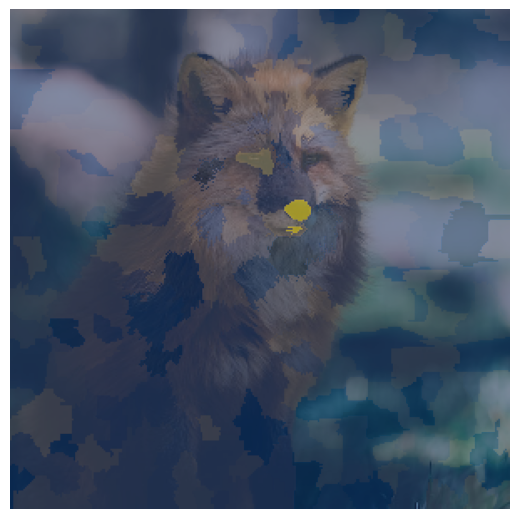

map_to_interpret_space: Quickshift


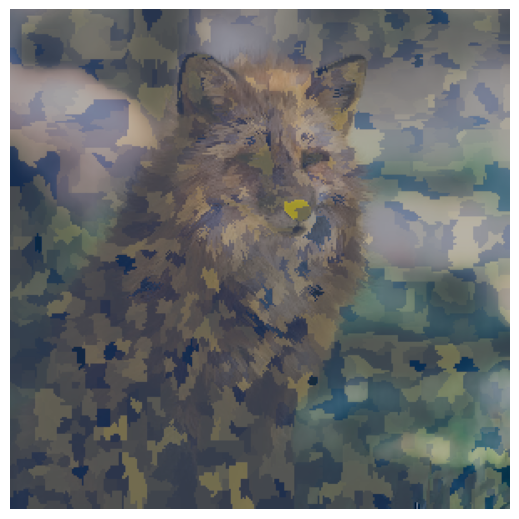

map_to_interpret_space: Felzenszwalb


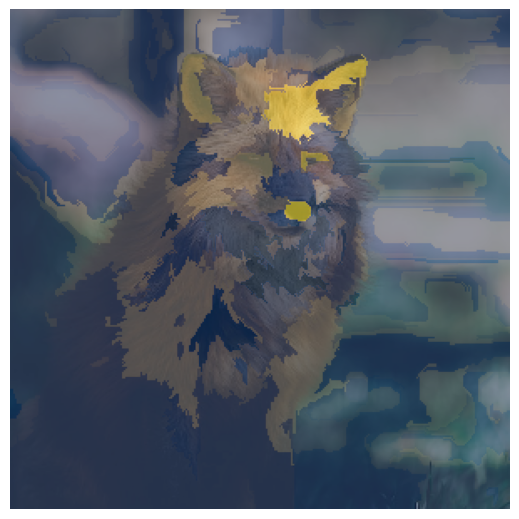

map_to_interpret_space: Slic


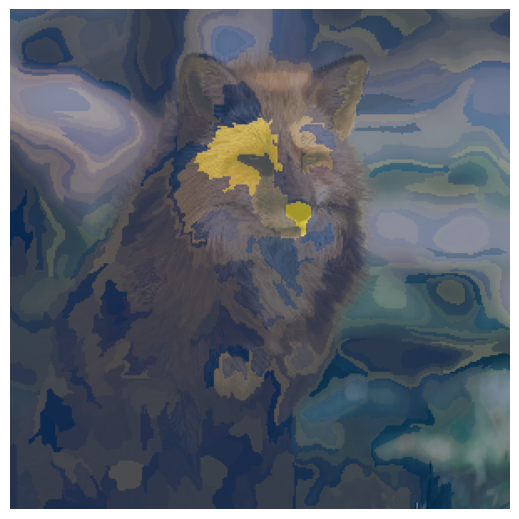

map_to_interpret_space: WaterShed


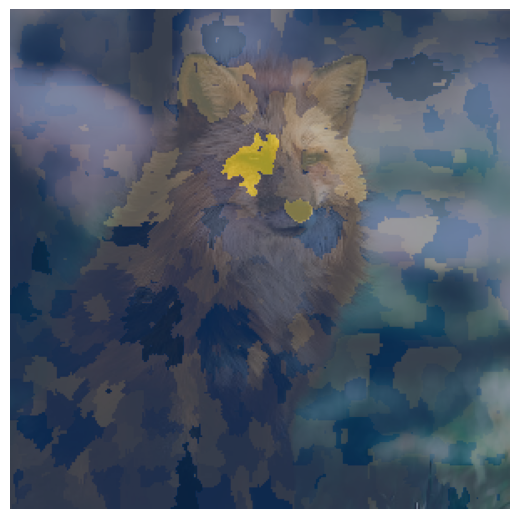

In [ ]:
batch_size = 16
map_to_interpret_spaces = {
    "Default (quickshift)": None,  # will use the default function, which is quickshift
    "Quickshift": lambda inp: tf.cast(quickshift(inp.numpy().astype('double'), ratio=0.5, kernel_size=1, max_dist=5), tf.int32),
    "Felzenszwalb": lambda inp: tf.cast(felzenszwalb(inp.numpy().astype('double'), scale=75, sigma=0.5, min_size=30), tf.int32),
    "Slic": lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=500, compactness=1, sigma=1, start_label=1), tf.int32),
    "WaterShed": lambda inp: tf.cast(watershed(sobel(rgb2gray(inp.numpy().astype('double'))), markers=500, compactness=0.0001), tf.int32),
}
nb_samples = 5000
ref_value = tf.fill((x.shape[-1]), 0.5)

for name, mapping in map_to_interpret_spaces.items():
    t = time()
    explainer = KernelShap(model,
                           map_to_interpret_space=mapping,
                           batch_size=batch_size,
                           nb_samples=nb_samples,
                           ref_value=ref_value)

    explanation = explainer.explain(x, y)
    print(f"map_to_interpret_space: {name}")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **nb_samples**

The `nb_samples` parameter is a positive integer indicating the number of different noise generated to build the estimator of the gradient. As known in probability:
- A too small number of sample will not provide a precise enough estimator, thus leading to noisy explanations.
- A too large number of sample can only have a good impact on the explanation, however it will impact the computation time linearly.

If the time computed in the following example are not linearly increasing with `nb_samples`, it is because of the colab computation ressource access that is not regular.

nb_samples: 200 -> 1.2761s


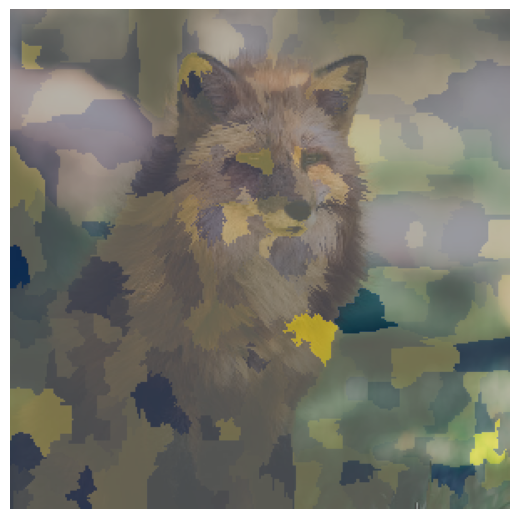

nb_samples: 1000 -> 5.1139s


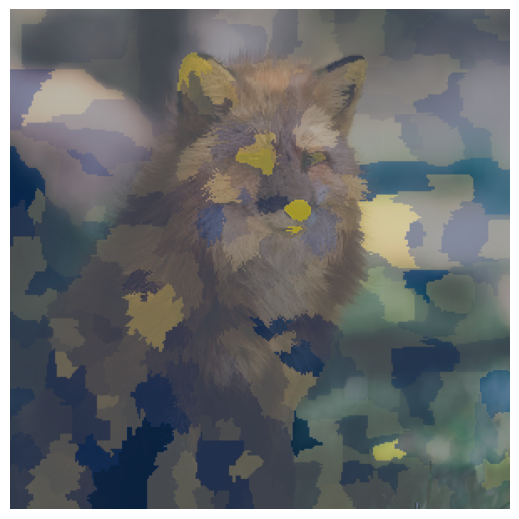

nb_samples: 4000 -> 20.4753s


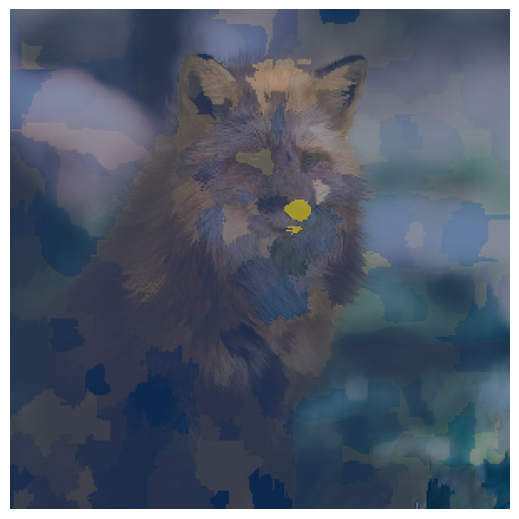

nb_samples: 10000 -> 40.9493s


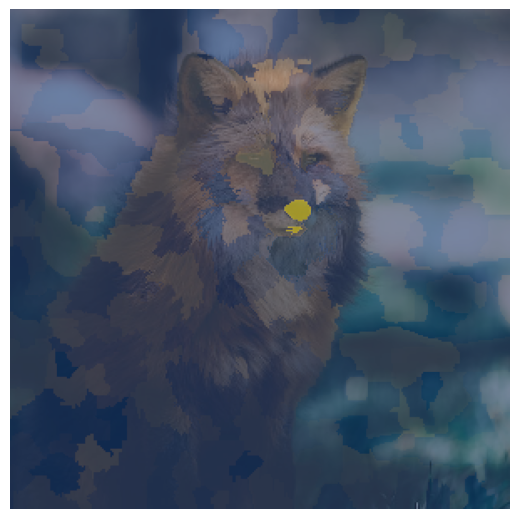

nb_samples: 25000 -> 101.2266s


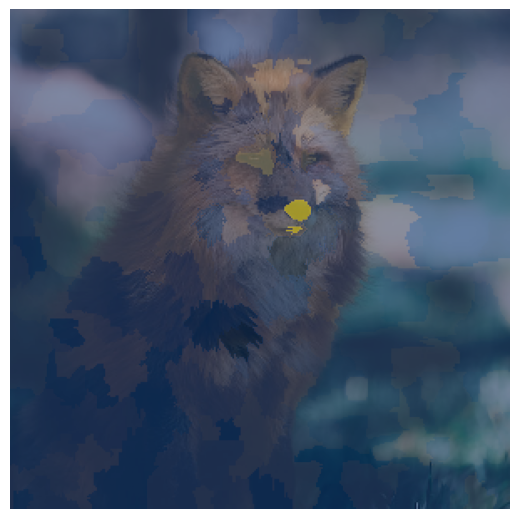

In [ ]:
batch_size = 16
map_to_interpret_space = None  # default function
nb_samples_list = [200, 1000, 4000, 10000, 25000]
ref_value = None  # default value (0.5, 0.5, 0.5)

for nb_samples in nb_samples_list:
    t = time()
    explainer = KernelShap(model,
                           map_to_interpret_space=map_to_interpret_space,
                           batch_size=batch_size,
                           nb_samples=nb_samples,
                           ref_value=ref_value)

    explanation = explainer.explain(x, y)
    print(f"nb_samples: {nb_samples} -> {round(time()-t, 4)}s")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **ref_value**

The `ref_value` parameter defines the reference value which replaces each feature when the corresponding interpretable feature is set to 0.

It should be provided as: a ndarray of shape (1) if there is no channels in your input and (C,) otherwise. The default ref value is set to (0.5, 0.5, 0.5) for inputs with 3 channels (corresponding to a grey pixel when inputs are normalized by 255) and to 0 otherwise.

It is similar to the `occlusion_value` from the Occlusion method. The the value should represent non-information. As such, 0 is often used.

However, many values could make sense, the mean or median of your values, the minimum or maximum of your values or even the middle between minimum and maximum.

We suggest that if you have several channels, you should represent the same thing (i.e all zeros or all means along the channel).


ref_value: [0. 0. 0.]


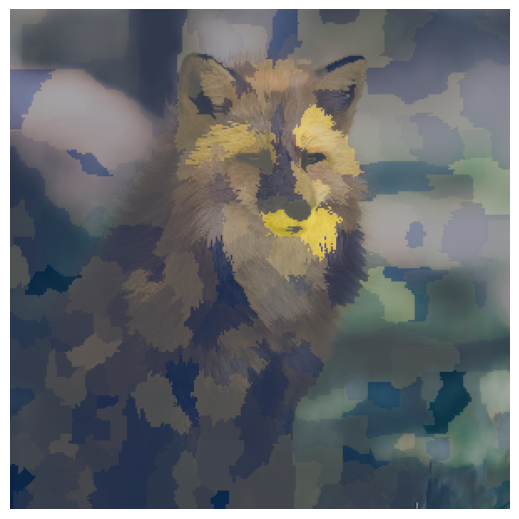

ref_value: [0.5 0.5 0.5]


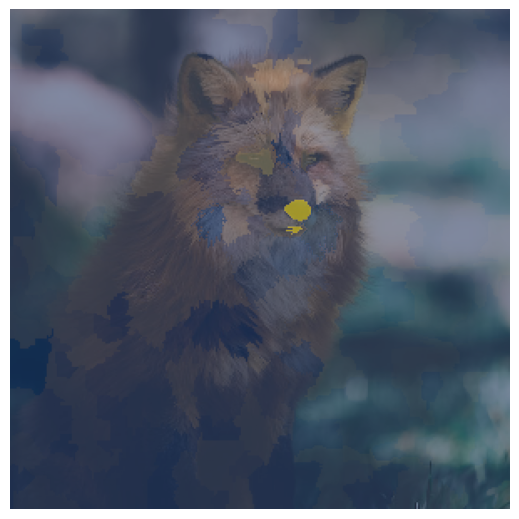

ref_value: [1. 1. 1.]


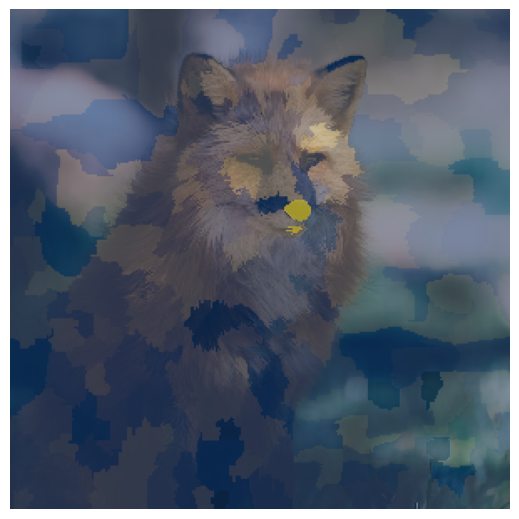

In [ ]:
batch_size = 16
map_to_interpret_space = None  # default function
nb_samples_list = 4000
# We have channels with 3 dimensions, ref_value should be the same
ref_values = [
    tf.fill((x.shape[-1]), 0.0),
    tf.fill((x.shape[-1]), 0.5),  # Default value
    tf.fill((x.shape[-1]), 1.0),
]

for ref_value in ref_values:
    explainer = KernelShap(model,
                           map_to_interpret_space=map_to_interpret_space,
                           batch_size=batch_size,
                           nb_samples=nb_samples,
                           ref_value=ref_value)

    explanation = explainer.explain(x, y)
    print(f"ref_value: {ref_value}")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

## <a name="lime_influence">Lime specific parameters influence</a>

This section will present the influence of each parameter specific to the Lime method, it will be accompanied by visualization to illustrate it. Each parameter will be described one by one in the following order:

- `interpretable_model`
- `similarity_kernel`
- `pertub_function`
- `distance_mode`
- `kernel_width`
- `prob`

### **interpretable_model**

The `interpretable_model` parameter represent an interpretable model object, this model is train on pertubed samples to approximate the original model locally. It correspond to the model behind the $g$ function in [the methods definition](#intro).

The default model is a Ridge regression model from scikit-learn. (KernelShap uses a linear regression).

It is difficult to predict the impact of this selection, thus without a deep understanding of what you are doing, it may not be relevant to change this parameter.

interpretable_model: Ridge(alpha=2)


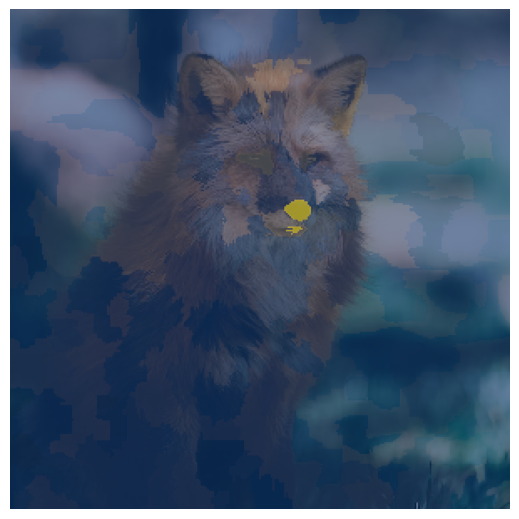

interpretable_model: LinearRegression()


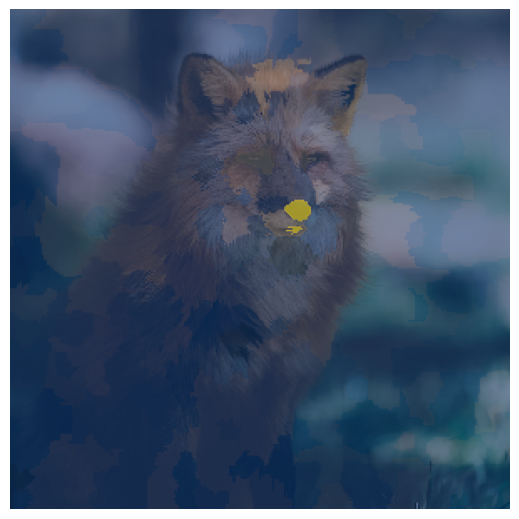

interpretable_model: Ridge(alpha=1)


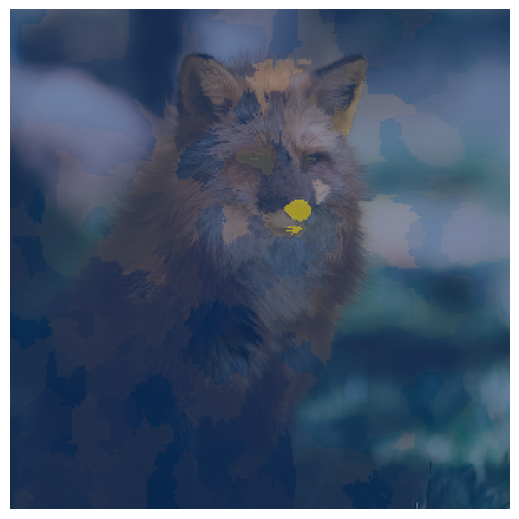

In [ ]:
# common parameters
common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # default function
    "nb_samples": 4000,
    "ref_value": None,  # default value
}

# Lime specific parameters
interpretable_models = [
    linear_model.Ridge(alpha=2),  # default function
    linear_model.LinearRegression(),
    linear_model.Ridge(alpha=1),
]
similarity_kernel = None  # default function
pertub_func = None  # default function
distance_mode = "euclidean"  # default value
kernel_width = 45.0  # default value
prob = 0.5  # default value


for interpretable_model in interpretable_models:
    explainer = Lime(**common_parameters,
                     interpretable_model = interpretable_model,
                     similarity_kernel = similarity_kernel,
                     pertub_func = pertub_func,
                     distance_mode = distance_mode,
                     kernel_width = kernel_width,
                     prob = prob)

    explanation = explainer.explain(x, y)

    print(f"interpretable_model: {str(interpretable_model)}")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **similarity_kernel**

The `similarity_kernel` is a function for measuring the similarity between perturbed samples and the original input. It takes the original image, the perturbed images and the mask of which input was perturbed. It is described as $\pi_x$ in [the methods definition](#intro).


The **default function** is the exponential of the negative value of the distance between the original input and the perturbed samples. It uses $ker$ the `kernel_width` value and $dist$ distance defined by the `distance_mode` parameter.

$$\pi_x(z) = exp(\frac{-dist(x, z)^2}{ker^2})$$

We will give examples of different similarity functions through the `distance_mode` and `kernel_width` parameters as creating a new similarity function will take more than one line. For examples you can refer to how `_get_exp_kernel_func()` creates the default `similarity_kernel` in [the lime.py source file](https://github.com/deel-ai/xplique/blob/1c493cf290970d05f1430cee04e2cd590d303f9c/xplique/attributions/lime.py#L496).

To see the `similarity_kernel` used by KernelShap, please refer to [the methods definition](#intro).

{'similarity_kernel': None, 'distance_mode': 'euclidean', 'kernel_width': 10.0}


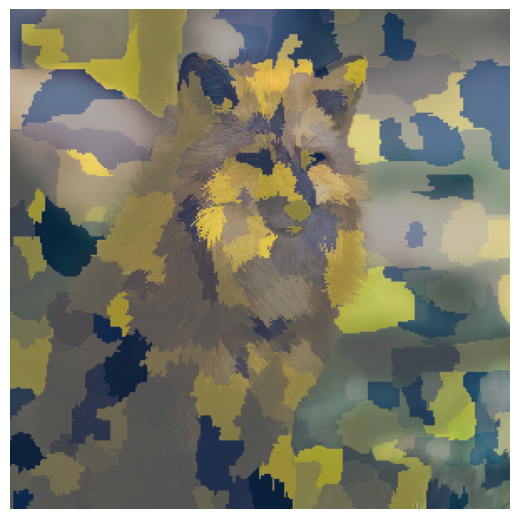

{'similarity_kernel': None, 'distance_mode': 'euclidean', 'kernel_width': 45.0}


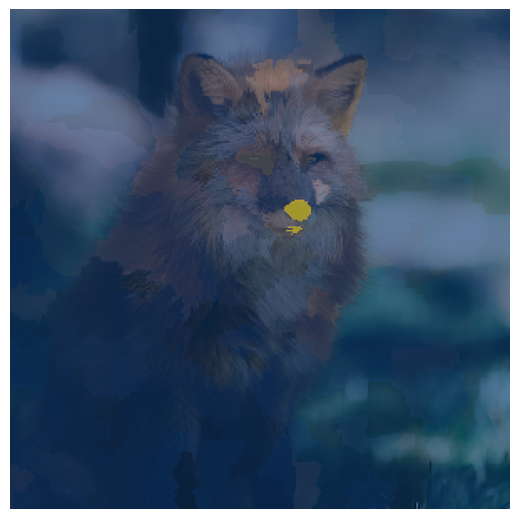

{'similarity_kernel': None, 'distance_mode': 'euclidean', 'kernel_width': 1000.0}


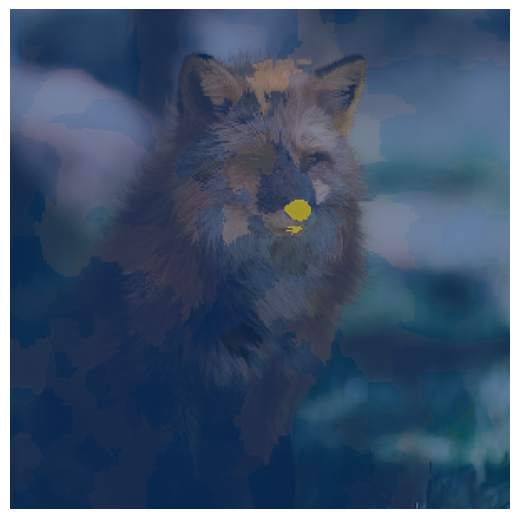

{'similarity_kernel': None, 'distance_mode': 'cosine', 'kernel_width': 10.0}


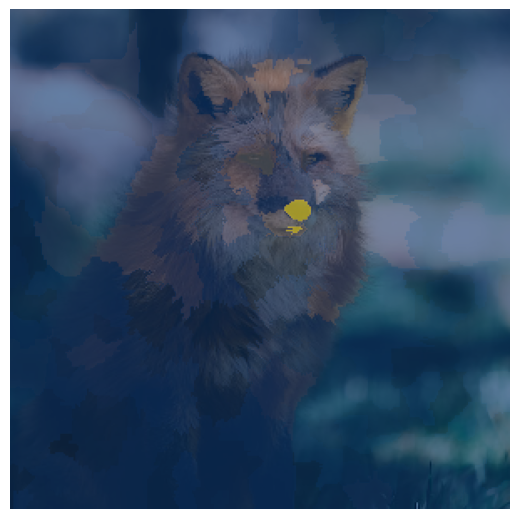

{'similarity_kernel': None, 'distance_mode': 'cosine', 'kernel_width': 45.0}


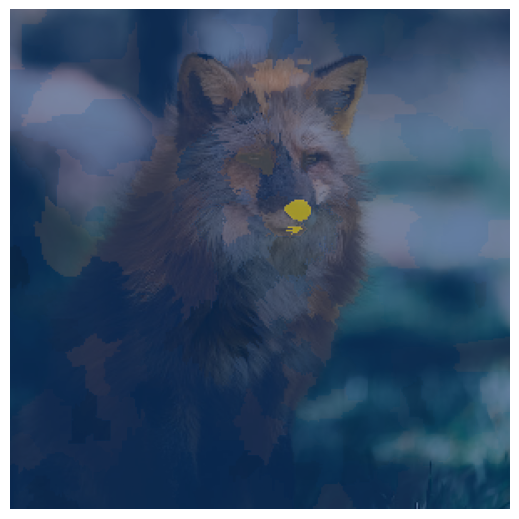

{'similarity_kernel': None, 'distance_mode': 'cosine', 'kernel_width': 1000.0}


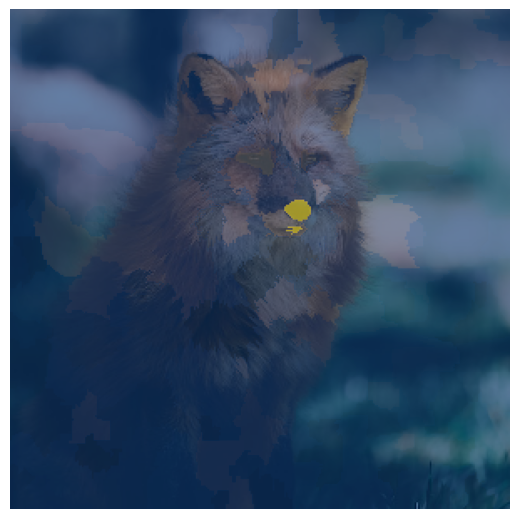

In [ ]:
# common parameters
common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # default function
    "nb_samples": 4000,
    "ref_value": None,  # default value
}

# Lime specific parameters
interpretable_model = linear_model.Ridge(alpha=2)  # default function
pertub_func = None  # default function
prob = 0.5  # default value

# Possible similarity settings
distance_modes = ["euclidean", "cosine"]
kernel_widths = [10.0, 45.0, 1000.0]
similarity_kernel_parameters = []
for distance_mode, kernel_width in product(distance_modes, kernel_widths):
    similarity_kernel_parameters.append({
        "similarity_kernel": None,  # default function
        "distance_mode": distance_mode,
        "kernel_width": kernel_width,
    })


for similarity_kernel_params in similarity_kernel_parameters:
    explainer = Lime(**common_parameters,
                     **similarity_kernel_params,
                     interpretable_model = interpretable_model,
                     pertub_func = pertub_func,
                     prob = prob)

    explanation = explainer.explain(x, y)
    print(similarity_kernel_params)

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **pertub_function**

The `pertub_function` is a function which generate perturbed interpretable samples in the interpretation space from the number of interpretable features (e.g nb of super pixel) and the number of perturbed samples you want per original input. Perturbed features are afterward set to `ref_value`.

The generated mask belong to $\{0,1\}^{num\_features}$. Where 1 indicates that we keep the corresponding feature (e.g super pixel) in the mapping.

The default function defined in [the lime.py source file](https://github.com/deel-ai/xplique/blob/1c493cf290970d05f1430cee04e2cd590d303f9c/xplique/attributions/lime.py#L453) generates random numbers between 0 and 1 and all values over `prob` are set to 1, 0 otherwise, `prob` is thus the probability to perturbate a feature. Creating a new `pertub_function` would take more than one line, thus we will use the `prob` parameter to modify it.

KernelShap randomly draws a number of features to perturb $k$ than randomly select $k$ features to perturb. More detail is given in the [methods definitions](#intro).

{'pertub_func': None, 'prob': 0.1}


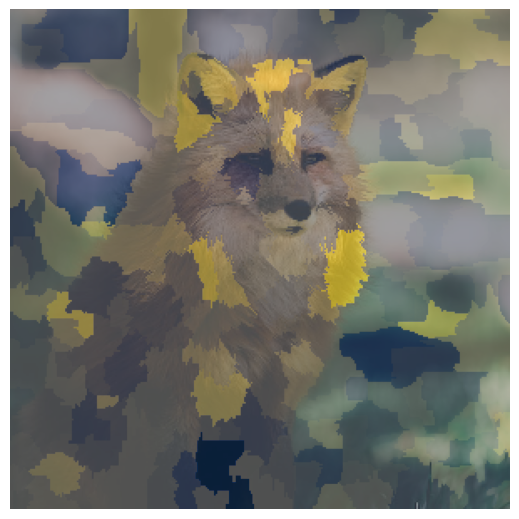

{'pertub_func': None, 'prob': 0.3}


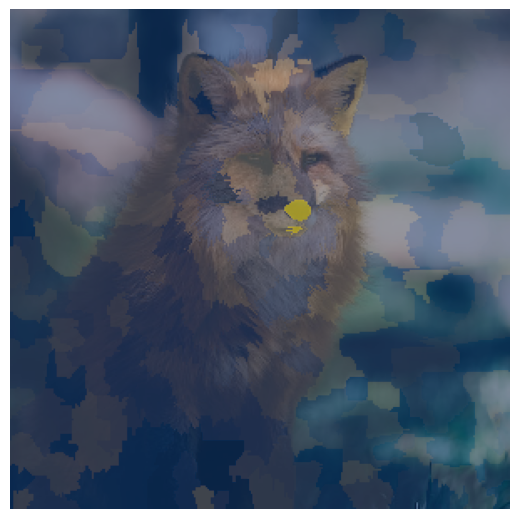

{'pertub_func': None, 'prob': 0.5}


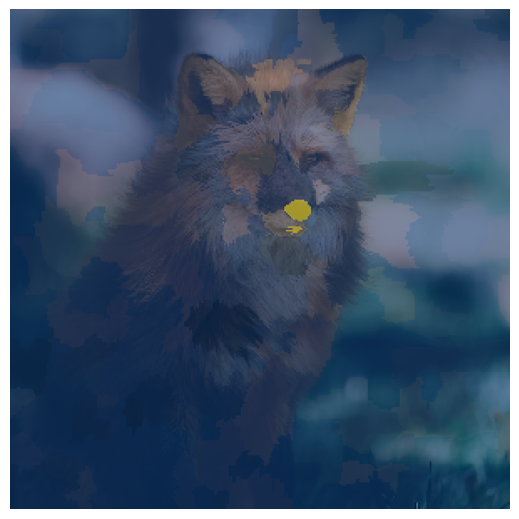

{'pertub_func': None, 'prob': 0.7}


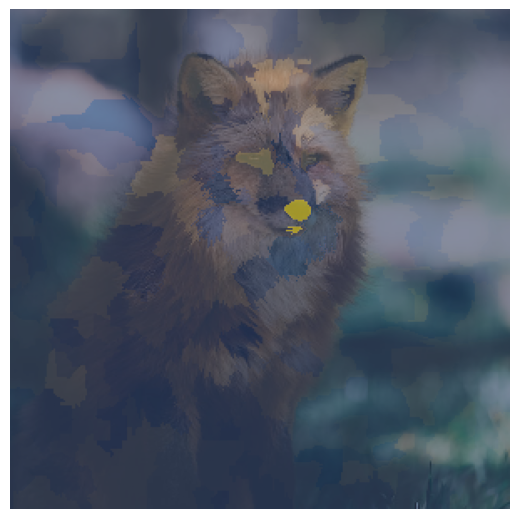

{'pertub_func': None, 'prob': 0.9}


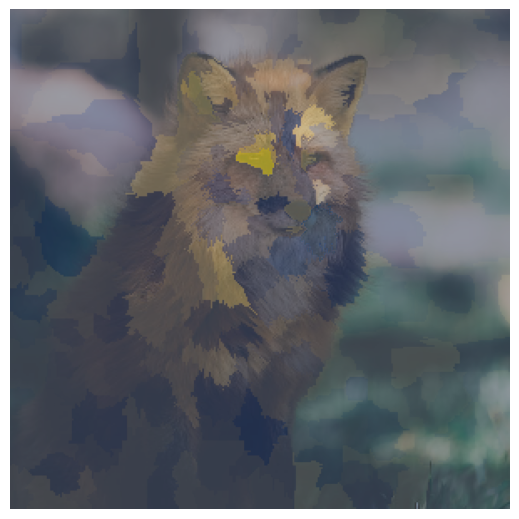

In [ ]:
# common parameters
common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # default function
    "nb_samples": 4000,
    "ref_value": None,
}

# Lime specific parameters
interpretable_model = linear_model.Ridge(alpha=2)  # default function
similarity_kernel = None  # default function
distance_mode = "euclidean"  # default value
kernel_width = 45.0  # default value

# Possible perturbation settings for default pertub_func
pertub_func = None
probs = [0.1, 0.3, 0.5, 0.7, 0.9]
pertub_func_parameters = []
for prob in probs:
    pertub_func_parameters.append({
        "pertub_func": pertub_func,
        "prob": prob,
    })


for pertub_func_params in pertub_func_parameters:
    explainer = Lime(**common_parameters,
                     **pertub_func_params,
                     interpretable_model = interpretable_model,
                     similarity_kernel = similarity_kernel,
                     distance_mode = distance_mode,
                     kernel_width = kernel_width)
    explanation = explainer.explain(x, y)
    print(pertub_func_params)

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()

### **distance_mode**

The `distance_mode` is the dist parameter used by the default `similarity_kernel` function. (See function and examples from the `similarity_kernel` paragraph).

Only support "euclidean" or "cosine" as values.

### **kernel_width**

The `kernel_width` is the width of the default `similarity_kernel` function. (See function and examples from the `similarity_kernel` paragraph).

A higher `kernel_width` will give more weight to distant perturbed samples compared to a smaller `kernel_width`.

- If `kernel_width` is too high, the interpretable model will learn on a too vast viciny of the initial image. The interpretable model will thus not be a good approximation of the initial model. (Too smooth).
- If `kernel_width` is too low, the interpretable model will only focus on a too small viciny of the initial image. The interpretable model will thus be really sensible to model instability. A higher `nb_samples` would be necessary to tackle it.

45 is a good value for 256*256 images. For tabular data, 1 is a good value.

The size of the input and the possible values should be taken into account when tuning this parameter.



### **prob**

The `prob` parameter is used by the default `perturb_function`. (See examples from the `pertub_function` paragraph). It determines the probability of a feature (super-pixel) to be perturbed. The default value is 0.5.

- A too high `prob` parameter value will generate images with most of their features perturbed, thus, a higher `nb_samples` will be needed.
- A too small `prob` parameter value will generate image with only a small number of features perturbed, thus, a higher `nb_samples` will also be needed.
